In [33]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from pptoolbox.visualization import initialize_theme
from pptoolbox.utils import preprocess, WAVELENGTHS_3NM_V1

cmaps = initialize_theme()

In [34]:
from sklearn.model_selection import cross_validate, GroupKFold
from pptoolbox.preprocessing import FeatureMask
from sklearn.base import clone

### Load Data

In [35]:
data_dir = Path("../models/platform/6548")
input_df = pd.read_csv(data_dir/'input.csv')
label_df = pd.read_csv(data_dir/'label.csv')
input_df.shape, label_df.shape

((160, 4), (40, 6))

In [36]:
X, y = preprocess(input_df, label_df, wavelengths=WAVELENGTHS_3NM_V1)
X.shape, y.shape

((160, 191), (160, 5))

# functions

In [37]:
base_wavelengths = np.arange(480, 1051, 3)

In [38]:
# slice the current wavelength to match the input required for the model
def coldrop(model_weights, base_wavelengths):
    difference = len(base_wavelengths) - len(model_weights.ravel())
    num_to_slice = difference/2
    return base_wavelengths[int(num_to_slice):int(-num_to_slice)] if num_to_slice != 0 else base_wavelengths

In [39]:
# adding a masking step to the pipeline
def get_new_model(model, mask_lower_limit = 650, mask_upper_limit = 950):
    model_weights = model[-1].coef_.ravel()

    if 'PCA' in model.named_steps:
        pca_loadings = model[-2].components_
        adjusted_weights =pca_loadings.T @ model_weights
        curr_wavelengths = coldrop(adjusted_weights, base_wavelengths)

    else:
        curr_wavelengths = coldrop(model_weights, base_wavelengths)

    mask = (curr_wavelengths < mask_lower_limit) | (curr_wavelengths > mask_upper_limit)
    new_model = clone(model)
    new_model.steps.insert(2, ('mask',FeatureMask(mask)))
    
    return new_model

In [40]:
def get_cv_results(model, X, y):
    compiled_results = {}
    if 'PCA' in model.named_steps:
        PC_max = model.named_steps.PCA.n_components+5 if model.named_steps.PCA.n_components+5 > 27 else 27
        for i in range(2, PC_max):
            model.named_steps.PCA.n_components = i
            results = cross_validate(model, X, y.values, cv=GroupKFold(n_splits=3), 
                        scoring=["r2", "neg_mean_absolute_error", "max_error", "neg_root_mean_squared_error"],
                        groups=X.index)
            mean_results = pd.DataFrame(results).mean().to_dict()
            compiled_results[i] = mean_results
    else:
        results = cross_validate(model, X, y.values, cv=GroupKFold(n_splits=3), 
                        scoring=["r2", "neg_mean_absolute_error", "max_error", "neg_root_mean_squared_error"],
                        groups=X.index)
        compiled_results = {
            "r2": results["test_r2"].mean(),
            "mae": -results["test_neg_mean_absolute_error"].mean(),
            "max_error": results["test_max_error"].mean(),
            "rmse": -results["test_neg_root_mean_squared_error"].mean()
        }
    return compiled_results

In [41]:
def display_results(model, results):
    if 'PCA' in model.named_steps:
        fig = pd.DataFrame(results).T.drop(columns=['fit_time', 'score_time']).plot()
        display(fig)
        display(pd.DataFrame(results).T.sort_values('test_r2', ascending=False).head(10))
    else:
        display(results)

In [42]:
def run_it_now(param, mask_lower_limit = 650, mask_upper_limit = 950):
    
    with open(data_dir/f'prediction/tasteprofile_model_{param}.pkl', 'rb') as f:
        model = pickle.load(f)
    print(f"Current Model for {param}")
    display(model)

    compiled_results = get_cv_results(model, X, y[param])
    print(f"Current results for {param}")
    display_results(model, compiled_results)

    new_model = get_new_model(model, mask_lower_limit, mask_upper_limit)
    print(f"New Model for {param}")
    display(new_model)

    compiled_results_new = get_cv_results(new_model, X, y[param])
    print(f"New results for {param}")
    display_results(new_model, compiled_results_new)

# Compare current and rebuilt model

## Brix Model

In [43]:
run_it_now('Brix')

Current Model for Brix


Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=13, scale=False))])

Current results for Brix


{'r2': -0.04001203960518821,
 'mae': 0.19054198114193546,
 'max_error': -0.5920709986313663,
 'rmse': 0.23676908877484307}

New Model for Brix


Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('mask',
                 FeatureMask(mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  T...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True]))),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=13, scale=False))])

New results for Brix


{'r2': -0.2829032711651298,
 'mae': 0.21940350047162563,
 'max_error': -0.6096342464144252,
 'rmse': 0.2633347959541694}

## T440

In [44]:
run_it_now('T440')

Current Model for T440


Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(scale=False))])

Current results for T440


{'r2': 0.6811930318007583,
 'mae': 1.5970605561807292,
 'max_error': -4.984938382576677,
 'rmse': 2.017734327845165}

New Model for T440


Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('mask',
                 FeatureMask(mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  Tru...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]))),
                ('PLS', PLSRegression(scale=False))])

New results for T440


{'r2': 0.6934158446624235,
 'mae': 1.5754007256066833,
 'max_error': -4.781582902513217,
 'rmse': 1.9900363768001708}

## T625

Current Model for T625


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=8, random_state=42)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.015810973510234,
                                            early_stopping=True,
                                            n_iter_no_change=7, random_state=42,
                                            shuffle=False))])

Current results for T625


<Axes: >

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_max_error,test_neg_root_mean_squared_error
16,0.071762,0.000668,0.287164,-0.371889,-1.585664,-0.557236
8,0.080561,0.000670,0.286867,-0.372082,-1.591950,-0.556715
9,0.070144,0.000000,0.286152,-0.373186,-1.586836,-0.557520
11,0.065777,0.005358,0.284385,-0.371993,-1.589325,-0.557909
12,0.071496,0.002129,0.282873,-0.372348,-1.589325,-0.558309
15,0.067501,0.005374,0.282507,-0.372398,-1.589128,-0.558371
14,0.071004,0.000680,0.282444,-0.372388,-1.590164,-0.558472
13,0.071939,0.000000,0.282135,-0.372607,-1.590637,-0.558593
17,0.072817,0.000565,0.280961,-0.372725,-1.589602,-0.559041
24,0.071227,0.002134,0.280889,-0.372221,-1.590286,-0.559209


New Model for T625


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('mask',
                 FeatureMask(mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  T...
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]))),
                ('PCA', PCA(n_components=26, random_state=42)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.015810973510234,
                                            early_stopping=True,
                                            n_iter_no_change=7, random_state=42,
                                            shuffle=False))])

New results for T625


<Axes: >

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_max_error,test_neg_root_mean_squared_error
17,0.055554,0.000680,0.251621,-0.388942,-1.551195,-0.565573
8,0.047405,0.000000,0.249928,-0.403429,-1.492008,-0.566360
21,0.052731,0.002344,0.248162,-0.389256,-1.551890,-0.566343
28,0.052673,0.000000,0.248069,-0.389490,-1.551783,-0.566386
23,0.048624,0.003136,0.248066,-0.389401,-1.551902,-0.566396
24,0.055062,0.000000,0.248051,-0.389509,-1.551800,-0.566408
26,0.071730,0.002917,0.247920,-0.389530,-1.552030,-0.566430
30,0.059686,0.001584,0.247891,-0.389450,-1.552296,-0.566481
29,0.056672,0.000000,0.247865,-0.389487,-1.552308,-0.566495
25,0.062249,0.000672,0.247844,-0.389413,-1.552140,-0.566458


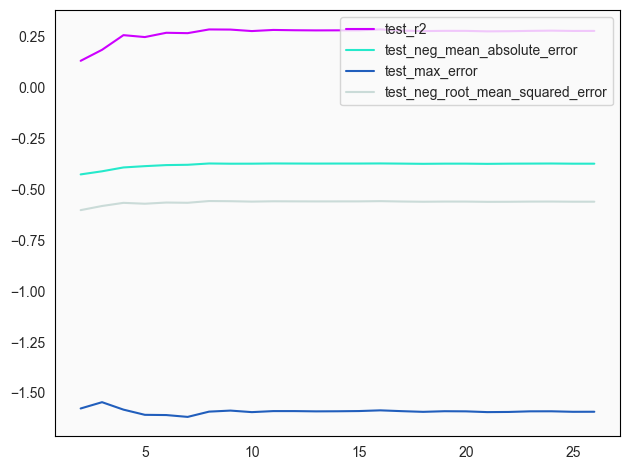

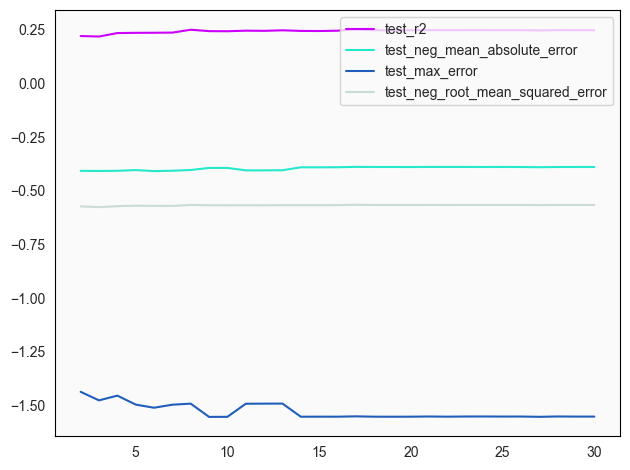

In [45]:
run_it_now('T625')

## TTA

In [46]:
run_it_now('TTA')

Current Model for TTA


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.022676502438312377,
                                            early_stopping=True,
                                            n_iter_no_change=48,
                                            random_state=42, shuffle=False))])

Current results for TTA


{'r2': -0.009702880844287387,
 'mae': 0.042233448601111286,
 'max_error': -0.09841083403217876,
 'rmse': 0.050678568810835704}

New Model for TTA


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('mask',
                 FeatureMask(mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  T...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]))),
                ('Paggro',
                 PassiveAggressiveRegressor(C=0.022676502438312377,
                                            early_stopping=True,
                                            n_iter_no_change=48,
                                            random_state=42, shuffle=False))])

New results for TTA


{'r2': -0.05535666350595814,
 'mae': 0.043837856352088866,
 'max_error': -0.09585179324752009,
 'rmse': 0.051681239181390955}

## Turbidity

Current Model for Turbidity


Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('Lars', Lars(random_state=42))])

Current results for Turbidity


<Axes: >

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_max_error,test_neg_root_mean_squared_error
5,0.033286,0.003106,-0.059188,-0.644099,-1.913142,-0.811411
6,0.032991,0.000000,-0.079635,-0.657499,-1.795764,-0.817447
28,0.044448,0.005550,-0.135876,-0.631709,-1.884893,-0.822949
31,0.039119,0.004264,-0.138634,-0.633466,-1.931390,-0.823106
32,0.038647,0.003223,-0.139118,-0.634269,-1.921540,-0.821555
29,0.046003,0.006095,-0.143579,-0.633526,-1.876858,-0.823798
4,0.034747,0.001171,-0.148053,-0.666468,-1.870438,-0.845031
26,0.038474,0.002237,-0.153058,-0.647622,-1.857018,-0.832219
30,0.036404,0.001841,-0.153195,-0.636428,-1.881322,-0.827314
24,0.032441,0.003160,-0.160305,-0.658609,-1.825069,-0.835485


New Model for Turbidity


Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('mask',
                 FeatureMask(mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  Tru...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True]))),
                ('PCA', PCA(n_components=35, random_state=42)),
                ('Lars', Lars(random_state=42))])

New results for Turbidity


<Axes: >

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_max_error,test_neg_root_mean_squared_error
5,0.016448,0.000000,-0.036678,-0.636389,-1.879291,-0.799513
4,0.015522,0.000672,-0.146155,-0.665588,-1.893406,-0.844191
3,0.011413,0.001105,-0.173260,-0.699553,-1.839896,-0.852859
6,0.015613,0.001257,-0.192128,-0.685789,-1.953190,-0.846316
2,0.013532,0.005865,-0.198400,-0.699668,-1.822832,-0.857256
9,0.015728,0.000000,-0.202952,-0.690522,-1.887367,-0.850322
7,0.013179,0.001042,-0.205821,-0.689648,-1.976822,-0.852088
8,0.014956,0.001342,-0.216171,-0.688398,-1.893381,-0.854427
10,0.017986,0.000000,-0.223788,-0.699270,-1.885062,-0.856355
14,0.013283,0.000672,-0.232899,-0.678028,-1.907421,-0.856832


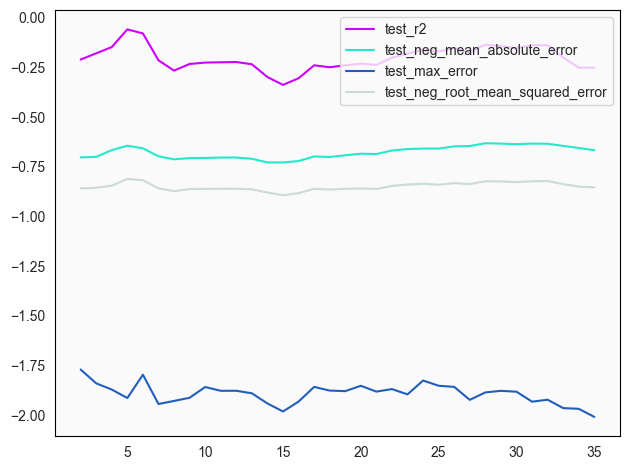

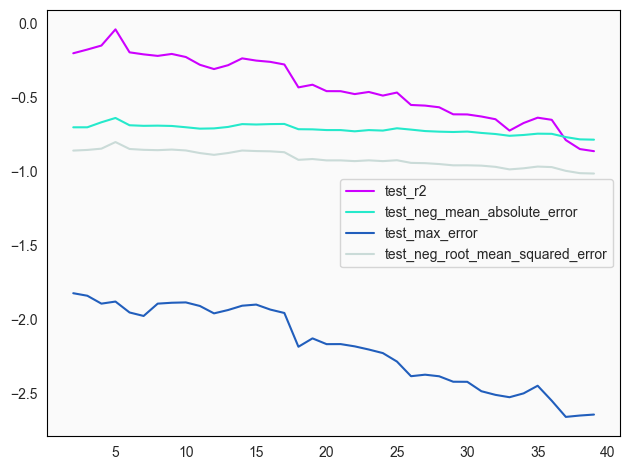

In [47]:
run_it_now('Turbidity')